# Time-Conditioned Masked Language Modeling

This project uses a simple approach to conditioning masked language models (MLMs) on time, enabling models to estimate **log-likelihoods over time**, i.e., `log p(x | t)`. This is particularly useful for tracking temporal dynamics in biological sequences (e.g. proteins, viral genomes), language corpora, or evolving behaviors.

Many sequence datasets (especially in biology, linguistics, and social data) include a timestamp for each observation.

Standard MLMs ignore this, treating all sequences as drawn from a single static distribution $p(x)$. Often, we are interested in

- How likely was a sequence at a given time?
- How does the distribution evolve?
- Can we model adaptation, drift, or innovation over time?

To answer these, we need to estimate log p(x | t).

## Idea

We modify a pretrained masked language model (MLM) to condition on a scalar time value `t`, enabling it to predict token distributions and compute likelihoods as functions of time.

We do this by injecting a time embedding into the model before the final prediction layer, optionally freezing the base model with `freeze_base`.

## Model Architecture

The model is a thin wrapper around a Hugging Face `AutoModelForMaskedLM` (e.g., `facebook/esm2_t6_8M_UR50D`, `bert-base-uncased`, etc.):

- A scalar time value `t` is passed alongside each input sequence.
- `t` is projected via an MLP to match the model's hidden size.
- The resulting embedding is **added** or **FiLM-modulated** (https://arxiv.org/abs/1709.07871) into the hidden states *after* the base model.

### Modes:
- Add: $h_{final} = h_{final} + time_{embedding}$
- **FiLM**: $h_{final} = \gamma(t) \cdot h_{final} + \beta(t)$

## Training Objective

We fine-tune the model using **masked language modeling (MLM)** loss:

```python
loss = CrossEntropy(logits[masked_positions], true_tokens[masked_positions])
```

To encourage temporal smoothness, we add a temporal KL divergence regularization between randomly perturbed timepoints:

```python
kl = KL(p(x | t) || p(x | t + $\delta t$))
total_loss = mlm_loss + kl_weight * kl
```
The kl_weight and perturbation scale $\delta t$ are user-controlled hyperparameters.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModelForMaskedLM, AutoTokenizer
import math

class SinusoidalTimeEmbedding(nn.Module):
    def __init__(
        self,
        out_dim,
        num_frequencies=16,
        max_period=10000,
        hidden_dims=[128, 128],
        activation=nn.ReLU,
        use_layernorm=False,
        dropout=0.0,
    ):
        super().__init__()
        self.out_dim = out_dim
        self.num_frequencies = num_frequencies
        self.max_period = max_period
        self.use_layernorm = use_layernorm

        # Frequencies: log scale, like transformer positions
        freq_bands = torch.exp(
            torch.linspace(0, math.log(max_period), num_frequencies)
        )
        self.register_buffer("frequencies", freq_bands)

        # Input dim = 2 * num_frequencies (sin and cos)
        input_dim = 2 * num_frequencies
        dims = [input_dim] + hidden_dims + [out_dim]

        layers = []
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            if i < len(dims) - 2:
                if use_layernorm:
                    layers.append(nn.LayerNorm(dims[i + 1]))
                layers.append(activation())
                if dropout > 0:
                    layers.append(nn.Dropout(dropout))

        self.mlp = nn.Sequential(*layers)

    def forward(self, t):  # t: [B] or [B, 1]
        if t.dim() == 1:
            t = t[:, None]  # [B, 1]
        angles = t * self.frequencies[None, :]  # [B, F]
        emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1)  # [B, 2F]
        return self.mlp(emb)  # [B, out_dim]
        
class TimeConditionedTransformer(nn.Module):
    def __init__(self, model_name="facebook/esm2_t6_8M_UR50D", d_time=64, mode="film", freeze_base=False):
        super().__init__()
        self.model = AutoModelForMaskedLM.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.hidden_size = self.model.config.hidden_size
        self.ignore_index = -100

        self.time_proj = SinusoidalTimeEmbedding(
            out_dim=self.hidden_size,
            num_frequencies=32,
            hidden_dims=[d_time, d_time],
            activation=nn.GELU,
            use_layernorm=True,
            dropout=0.0,
        )

        self.mode = mode
        if mode == "film": 
            # Feature-wise Linear Modulation (https://arxiv.org/abs/1709.07871)
            self.time_gamma = nn.Linear(self.hidden_size, self.hidden_size)
            self.time_beta = nn.Linear(self.hidden_size, self.hidden_size)

        if freeze_base:
            for param in self.model.base_model.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask, time_scalar, labels=None):
        # Run the base model and intercept hidden states
        outputs = self.model.base_model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        hidden = outputs.last_hidden_state  # [B, L, D]

        if time_scalar.dim() == 1:
            time_scalar = time_scalar[:, None]
        t_embed = self.time_proj(time_scalar).unsqueeze(1).expand_as(hidden)

        if self.mode == "add":
            hidden = hidden + t_embed
        elif self.mode == "film":
            gamma = self.time_gamma(t_embed)
            beta = self.time_beta(t_embed)
            hidden = gamma * hidden + beta

        # Pass modified hidden states through LM head
        logits = self.model.lm_head(hidden)

        if labels is not None:
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                labels.view(-1),
                ignore_index=self.ignore_index
            )
            return logits, loss
        return logits, None

    def compute_log_likelihood(self, input_ids, attention_mask, labels, time_scalar):
        logits, _ = self.forward(input_ids, attention_mask, time_scalar)
        log_probs = F.log_softmax(logits, dim=-1)
        log_likelihood = log_probs.gather(-1, labels.unsqueeze(-1)).squeeze(-1)
        mask = (labels != self.ignore_index)
        return log_likelihood[mask].sum()
    
    def tokenize_batch(self, sequences, max_length=1024):
        return self.tokenizer(sequences, padding=True, truncation=True, return_tensors="pt", max_length=max_length)

def mask_tokens(inputs, tokenizer, mlm_probability=0.15, mask_ratio=0.8, random_ratio=0.1, ignore_index=-100):
    """
    Prepare masked tokens inputs/labels for masked language modeling.
    Inputs:
        inputs (torch.Tensor): tokenized input_ids [batch_size, seq_length]
        tokenizer: HuggingFace tokenizer (must have mask_token_id)
        mlm_probability (float): probability of masking a token
    Returns:
        masked_inputs (torch.Tensor): input ids with some tokens replaced with [MASK]
        labels (torch.Tensor): same shape, where masked tokens are replaced with original ids, others with -100
    """
    labels = inputs.clone()
    
    # Create mask for tokens to mask (excluding special tokens like CLS, SEP, PAD)
    probability_matrix = torch.full(labels.shape, mlm_probability)
    special_tokens_mask = [
        tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()
    ]
    special_tokens_mask = torch.tensor(special_tokens_mask, dtype=torch.bool)
    probability_matrix.masked_fill_(special_tokens_mask, value=0.0)
    
    masked_indices = torch.bernoulli(probability_matrix).bool()
    labels[~masked_indices] = ignore_index  # Only compute loss on masked tokens

    # Now split the masked indices into [MASK], random, and unchanged
    total_masked = masked_indices.sum()

    # Make sure there are enough masked positions to split
    if total_masked == 0:
        return inputs, labels

    mask_token_indices = masked_indices.clone()
    random_token_indices = masked_indices.clone()
    unchanged_indices = masked_indices.clone()

    rand = torch.rand(labels.shape)

    # [MASK] token: mask_ratio (e.g., 80%)
    mask_token_indices &= rand < mask_ratio

    # Random tokens: random_ratio (e.g., 10%)
    random_token_indices &= (rand >= mask_ratio) & (rand < mask_ratio + random_ratio)

    # Unchanged tokens: remaining (e.g., 10%)
    unchanged_indices &= rand >= mask_ratio + random_ratio

    # Apply replacements
    inputs[mask_token_indices] = tokenizer.mask_token_id

    random_words = torch.randint(len(tokenizer), labels.shape, dtype=torch.long)
    inputs[random_token_indices] = random_words[random_token_indices]

    return inputs, labels

/Users/marlinfiggins/Documents/evo_diffusion/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = TimeConditionedTransformer("facebook/esm2_t6_8M_UR50D", mode="add")

batch = model.tokenize_batch(["MAIVMGR", "GAVLIP"])  # Protein sequences
time = torch.tensor([0.0, 1.0])
labels = batch["input_ids"].clone()

logits, loss = model(
    input_ids=batch["input_ids"],
    attention_mask=batch["attention_mask"],
    time_scalar=time,
    labels=labels
)

In [3]:
logits.shape # [batch, length, alphabet_size]

torch.Size([2, 9, 33])

In [4]:
logp_xt = model.compute_log_likelihood(
    input_ids=batch["input_ids"],
    attention_mask=batch["attention_mask"],
    labels=labels,
    time_scalar=time
)
print(f"log p(x | t): {logp_xt.item():.4f}")

log p(x | t): -29.1047


In [5]:
from torch.utils.data import Dataset, DataLoader
import torch


class TimeConditionedSequenceDataset(Dataset):
    def __init__(self, sequences, times, tokenizer, max_length=1024):
        """
        Args:
            sequences (List[str]): List of sequences (e.g., protein sequences or text).
            times (List[float]): Time scalar for each sequence.
            tokenizer: HuggingFace tokenizer.
            max_length (int): Max sequence length.
        """
        assert len(sequences) == len(times), "Mismatched sequence/time lengths."
        self.sequences = sequences
        self.times = torch.tensor(times, dtype=torch.float32)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.sequences[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "time": self.times[idx]
        }
        
def collate_fn(batch):
    input_ids = torch.stack([item["input_ids"] for item in batch])
    attention_mask = torch.stack([item["attention_mask"] for item in batch])
    time = torch.stack([item["time"] for item in batch])
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "time": time
    }

In [6]:
from torch.utils.data import DataLoader

sequences = ["MAIVMGRMAIVMGR", "GAVLIPMAIVMGR", "MFQKMFQKMFQK", "LCTKRMFQK"]
times = [0.0, 1.0, 2.0, 3.0]  # corresponding times

tokenizer = TimeConditionedTransformer().tokenizer  # load tokenizer from model
dataset = TimeConditionedSequenceDataset(sequences, times, tokenizer)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [7]:
class TimeConditionedTrainer:
    def __init__(self, model, optimizer, device="cpu"):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.device = device
        self.history = {
            "step_losses": [],
            "step_kls": [],
            "step_totals": [],
            "epoch_losses": [],
        }

    def compute_temporal_kl(self, batch, time_scalar, perturbation_scale=0.1):
        input_ids = batch["input_ids"].to(self.device)
        attention_mask = batch["attention_mask"].to(self.device)

        t1 = time_scalar.to(self.device)
        delta = perturbation_scale * torch.randn_like(t1)
        t2 = t1 + delta

        # Get p(x|t1) and p(x|t2)
        logits1, _ = self.model(input_ids, attention_mask, t1)
        logits2, _ = self.model(input_ids, attention_mask, t2)

        log_probs1 = F.log_softmax(logits1, dim=-1)
        probs2 = F.softmax(logits2, dim=-1)
        mask = input_ids != self.model.ignore_index
        return F.kl_div(log_probs1[mask], probs2[mask], reduction="batchmean", log_target=False)

    def train_batch(self, batch, time_scalar, kl_weight=0.1, perturbation_scale=0.1, mlm_probability=0.15):
        self.model.train()
        input_ids = batch["input_ids"].to(self.device)
        attention_mask = batch["attention_mask"].to(self.device)
        time_scalar = time_scalar.to(self.device)
    
        masked_input_ids, labels = mask_tokens(input_ids.clone(), self.model.tokenizer, mlm_probability=mlm_probability)
        _, loss = self.model(masked_input_ids, attention_mask, time_scalar, labels)
        kl = self.compute_temporal_kl(batch, time_scalar, perturbation_scale)
        total_loss = loss + kl_weight * kl

        total_loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        return loss.item(), kl.item(), total_loss.item()

    def train_loop(self, dataloader, epochs=3, kl_weight=0.1, perturbation_scale=0.01):
        for epoch in range(epochs):
            epoch_loss = 0.0
            for i, batch in enumerate(dataloader):
                loss, kl, total = self.train_batch(batch, batch["time"], kl_weight, perturbation_scale)
                self.history["step_losses"].append(loss)
                self.history["step_kls"].append(kl)
                self.history["step_totals"].append(total)
                epoch_loss += loss
            avg_epoch_loss = epoch_loss / len(dataloader)
            self.history["epoch_losses"].append(avg_epoch_loss)
            print(f"Epoch {epoch} completed. Avg Loss: {avg_epoch_loss:.4f}")

    def save_checkpoint(self, path, epoch=None, step=None):
        checkpoint = {
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
            "epoch": epoch,
            "step": step,
            "history": self.history,
        }
        torch.save(checkpoint, path)
        print(f"Checkpoint saved to {path}")
        
def load_checkpoint(model, optimizer, path, map_location="cpu"):
    checkpoint = torch.load(path, map_location=map_location)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch = checkpoint.get("epoch", 0)
    step = checkpoint.get("step", 0)
    history = checkpoint.get("history", {})
    print(f"Loaded checkpoint from {path} (epoch {epoch}, step {step})")
    return model, optimizer, epoch, step, history

In [8]:
model = TimeConditionedTransformer(freeze_base=True)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
trainer = TimeConditionedTrainer(model, optimizer)
trainer.train_loop(dataloader, kl_weight=1e-1, epochs=10)

Epoch 0 completed. Avg Loss: 3.8651
Epoch 1 completed. Avg Loss: 2.9367
Epoch 2 completed. Avg Loss: 3.0643
Epoch 3 completed. Avg Loss: 3.5739
Epoch 4 completed. Avg Loss: 2.6161
Epoch 5 completed. Avg Loss: 2.1178
Epoch 6 completed. Avg Loss: 2.6035
Epoch 7 completed. Avg Loss: 3.0433
Epoch 8 completed. Avg Loss: 2.0612
Epoch 9 completed. Avg Loss: 1.9983


In [9]:
def compute_logp_xt(model, sequence, t_scalar, device="cpu"):
    model.eval()
    with torch.no_grad():
        batch = model.tokenize_batch([sequence])
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = input_ids.clone()
        t_tensor = torch.tensor([t_scalar], device=device)

        logp = model.compute_log_likelihood(input_ids, attention_mask, labels, t_tensor)
        return logp.item()

In [10]:
logpx = compute_logp_xt(model, sequences[0], t_scalar=0.0)
print(f"log p(x | t=0.0): {logpx:.4f}")

logpx = compute_logp_xt(model, sequences[0], t_scalar=1.0)
print(f"log p(x | t=1.0): {logpx:.4f}")

logpx = compute_logp_xt(model, sequences[0], t_scalar=2.0)
print(f"log p(x | t=2.0): {logpx:.4f}")

log p(x | t=0.0): -50.2497
log p(x | t=1.0): -48.8261
log p(x | t=2.0): -61.9359


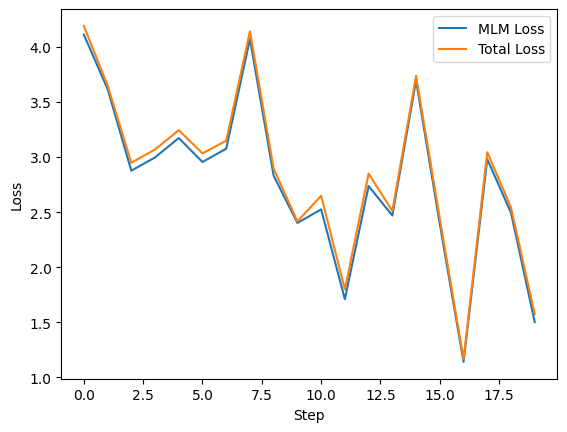

In [11]:
import matplotlib.pyplot as plt


plt.plot(trainer.history["step_losses"], label="MLM Loss")
#plt.plot(trainer.history["step_kls"], label="KL Reg")
plt.plot(trainer.history["step_totals"], label="Total Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()

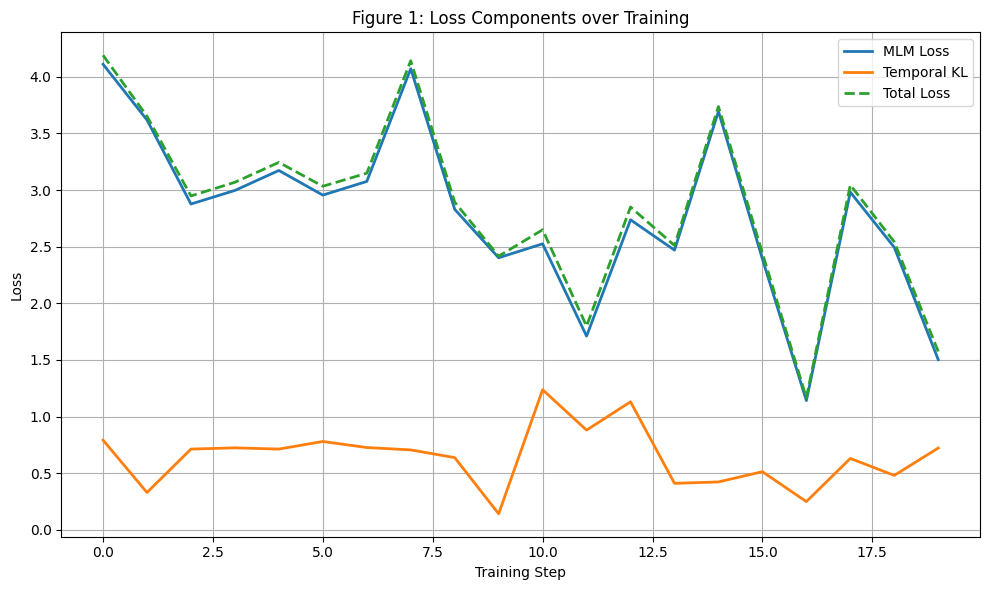

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(trainer.history["step_losses"], label="MLM Loss", linewidth=2)
plt.plot(trainer.history["step_kls"], label="Temporal KL", linewidth=2)
plt.plot(trainer.history["step_totals"], label="Total Loss", linewidth=2, linestyle='--')
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Figure 1: Loss Components over Training")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

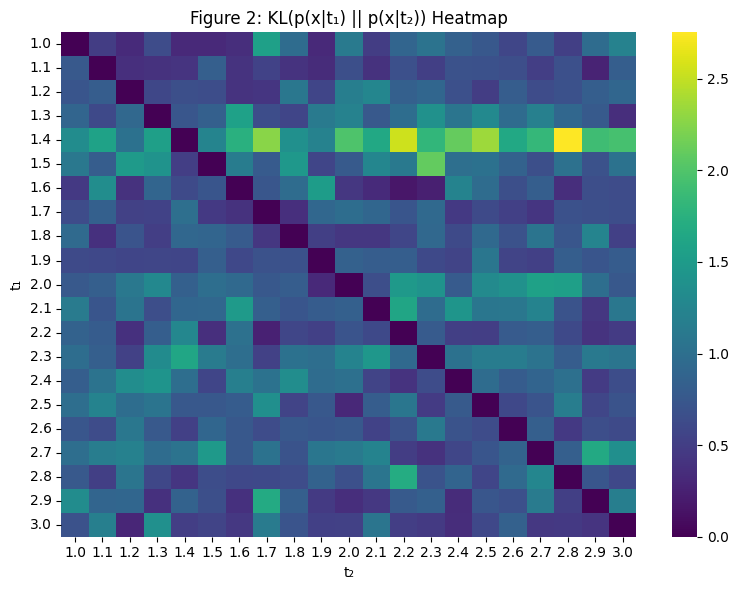

In [14]:
import seaborn as sns
import numpy as np
times = torch.tensor(np.linspace(1, 3, 21), dtype=torch.float32)
kl_matrix = np.zeros((len(times), len(times)))
batch_size = batch["input_ids"].shape[0]
for i, t1 in enumerate(times):
    for j, t2 in enumerate(times):
        kl_matrix[i, j] = trainer.compute_temporal_kl(batch, torch.tensor([t1]*batch_size), perturbation_scale=t2-t1).item()

plt.figure(figsize=(8, 6))
times = np.array(times)
sns.heatmap(kl_matrix, xticklabels=np.round(times, 2), yticklabels=np.round(times, 2), cmap="viridis")
plt.xlabel("t₂")
plt.ylabel("t₁")
plt.title("Figure 2: KL(p(x|t₁) || p(x|t₂)) Heatmap")
plt.tight_layout()
plt.show()